In [1]:
# Package imports
%matplotlib inline
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import math
import pdb
import pickle
import pandas as pd
from sklearn import preprocessing
import seaborn as sns
import os
import time
from sklearn.manifold import TSNE
#from datasets import dataset_utils

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Main slim library
slim = tf.contrib.slim

In [12]:
# Model Architecture Defs
def mlp_model(inputs, net_arch, is_training, scope="mlp", net_type='mlpnet'):
    """Creates the regression model.

    Args:
        inputs: A node that yields a `Tensor` of size [batch_size, dimensions].
        net_arch: A model architecture with node_sizes, dropout, and other hyper-parmas
        is_training: Whether or not we're currently training the model.
        scope: An optional variable_op scope for the model.

    Returns:
        predictions: 1-D `Tensor` of shape [batch_size] of responses.
        end_points: A dict of end points representing the hidden layers.
    """
    end_points = {}
    if net_type == 'mlpnet':
        with tf.variable_scope(scope, 'mlp', [inputs]):
            # Set the default weight _regularizer and acvitation for each fully_connected layer.
            with slim.arg_scope([slim.fully_connected], activation_fn=tf.nn.relu,
                                weights_regularizer=slim.l2_regularizer(net_arch['reg'])):

                # Creates a fully connected layer from the inputs 
                net = slim.fully_connected(inputs, net_arch['l1'], normalizer_fn=slim.batch_norm, scope='fc1')
                end_points['fc1'] = net                
                net = slim.dropout(net, net_arch['keep_p'], is_training=is_training,scope='drop1')

                # Adds another fully connected layer 
                net = slim.fully_connected(net, net_arch['l2'], normalizer_fn=slim.batch_norm, scope='fc2')                                                
                end_points['fc2'] = net                
                net = slim.dropout(net, net_arch['keep_p'], is_training=is_training)
                
                # Adds another fully connected layer 
                net = slim.fully_connected(net, net_arch['l3'], normalizer_fn=slim.batch_norm, scope='fc3')                                                
                end_points['fc3'] = net 
                net = slim.dropout(net, net_arch['keep_p'], is_training=is_training)
                
                # Adds another fully connected layer 
                net = slim.fully_connected(net, net_arch['l3'], normalizer_fn=slim.batch_norm, scope='fc4')                                                
                end_points['fc4'] = net 
                net = slim.dropout(net, net_arch['keep_p'], is_training=is_training)
                
# #                  # Adds another fully connected layer 
#                 net = slim.fully_connected(net, net_arch['l3'], normalizer_fn=slim.batch_norm, scope='fc5')                                                
#                 end_points['fc5'] = net 
#                 net = slim.dropout(net, net_arch['keep_p'], is_training=is_training)

                # Creates a fully-connected layer with a single hidden unit. Note that the
                # layer is made linear by setting activation_fn=None.
                predictions = slim.fully_connected(net, net_arch['output'], 
                                                   normalizer_fn=slim.batch_norm, scope='prediction')               
                end_points['out'] = predictions                
        
    elif net_type == 'mult_mod':        
        with tf.variable_scope(scope, 'mult_mod', [inputs]):            
            d = inputs['d']
            cs = inputs['cs']
            attr = inputs['attr']
            if net_arch['dist_mod'] == 'embed':
                attr_mod = slim.fully_connected(attr, net_arch['aux_embed'], activation_fn=tf.nn.relu,                                                 
                                                normalizer_fn=slim.batch_norm, scope='attr_mod')
                
                d_mod = tf.multiply(d,attr_mod)
                print('shapes: d:{}, attr:{}, attr_mod {}, dmod {}'.format(d.shape,attr.shape,
                                                                       attr_mod.shape,d_mod.shape))
            
                predictions = slim.fully_connected(tf.concat([d_mod,cs],1), net_arch['aux_out'], activation_fn=None,
                                               normalizer_fn=slim.batch_norm, scope='aux_prediction')
                
                
            elif net_arch['dist_mod'] == 'mult':
                d_mod = tf.multiply(d,attr)
                print('shapes: d:{}, attr:{}, dmod {}'.format(d.shape,attr.shape,d_mod.shape))
                predictions = slim.fully_connected(tf.concat([d_mod,cs],1), net_arch['aux_out'], activation_fn=None,
                                               normalizer_fn=slim.batch_norm,
                                               weights_regularizer=slim.l2_regularizer(net_arch['reg']),
                                               scope='aux_prediction')
                
            else:
                d_mod = d     
                predictions = slim.fully_connected(tf.concat([d_mod,cs],1), net_arch['aux_out'], activation_fn=None,
                                               normalizer_fn=slim.batch_norm,
                                               weights_regularizer=slim.l2_regularizer(net_arch['reg']),
                                               scope='aux_prediction')
                            
            
            end_points['aux_out'] = predictions
            if d_mod.shape[1] > 1:
                end_points['d_mod'] = tf.reduce_sum(tf.pow(d_mod,2),1,keep_dims=True)
            else:
                end_points['d_mod'] = d_mod
            end_points['dist'] = d
            
    elif net_type == 'dvec_mod':        
        with tf.variable_scope(scope, 'dvec_mod', [inputs]):            
            dvec = inputs['d']
            cs = inputs['cs']
            attr = inputs['attr']
            
            if net_arch['dist_mod'] == 'embed':
                attr_mod = slim.fully_connected(attr, net_arch['aux_embed'], activation_fn=tf.nn.relu, 
                                                normalizer_fn=slim.batch_norm,scope='attr_mod')            
                
                d_mod = tf.multiply(dvec,attr_mod,name='d_mod')
                print('shapes: d:{}, attr:{}, attr_mod {}, dmod {}'.format(dvec.shape,attr.shape,
                                                                       attr_mod.shape,d_mod.shape))                               
            else:
                d_mod = dvec
                print('shapes: d:{}, dmod {}'.format(dvec.shape,d_mod.shape))   
            
            
            net = slim.fully_connected(tf.concat([d_mod,cs],1), net_arch['output'], activation_fn=tf.nn.relu, 
                                        weights_regularizer=slim.l2_regularizer(net_arch['reg']),
                                        normalizer_fn=slim.batch_norm, scope='fc_d_mod_cs') 
            net = slim.dropout(net, net_arch['keep_p'], is_training=is_training)

            predictions = slim.fully_connected(net, net_arch['aux_out'], activation_fn=None, 
                                               normalizer_fn=slim.batch_norm, scope='aux_prediction')


            end_points['aux_out'] = predictions
            end_points['d_mod'] = tf.reduce_sum(tf.pow(d_mod,2),1,keep_dims=True)
            end_points['dist'] = tf.reduce_sum(tf.pow(dvec,2),1,keep_dims=True)

    else:
        print('Unknown Net Arch')

    return end_points


def produce_batch(batch_size, noise=0.2):
    xs = np.random.random(size=[batch_size, 1]) * 4
    ys = np.round(xs + np.random.normal(size=[batch_size, 1], scale=noise))
    return [xs.astype(np.float32), ys.astype(np.int32)]


def convert_data_to_tensors(x, y):
    inputs = tf.constant(x)
    inputs.set_shape([None, 1])
    
    outputs = tf.constant(y)
    outputs.set_shape([None, 1])
    return inputs, outputs

In [13]:
# Load data
baseline_dir = '/projects/nbhagwat/Traj_prediction/ADNI/exp_setup/'
demo_cols = ['AGE','APOE4']
cohort = 'ALL_ADNI'
clinical_scale = 'ADAS13'
exp_name = 'Exp_602_{}_traj_{}_tp_var_tp'.format(cohort,clinical_scale)
use_cs = False
use_ct = True
var_tp = True
shuffle_labels = False # What's your performance with random labels. 
scale_data = False
feat_sufix = ''

exp_setup_path = baseline_dir + 'KFolds/' + exp_name + '_sKF.pkl'

with open(exp_setup_path, 'rb') as f:
    exp_setup = pickle.load(f, encoding='latin') 


#Check if loading the correct experimental setup
if exp_name != exp_setup['exp_name']:
    print('Incorrect exp_name. Selected:{}, Retrieved:{}'.format(exp_name, exp_setup['exp_name']))

else:
    print('exp_name: {}'.format(exp_name))
    
    df = exp_setup['df']
    kf = exp_setup['sKF']
    
    feat_cols = []    
    
    if use_cs:
        print('using CS columns')
        if var_tp:
            cs_cols = ['{}_bl'.format(clinical_scale),'{}_var_tp'.format(clinical_scale)] #+ demo_cols
        else:
            cs_cols = ['{}_bl'.format(clinical_scale)] + demo_cols
        feat_cols = feat_cols + cs_cols
        feat_sufix = feat_sufix + '_CS'
        print(len(feat_cols))
        
        
    if use_ct:   
        print('using CT columns')
        if var_tp:
            ct_cols_bl = list(df.columns[pd.Series(df.columns).str.contains('CT_bl')])
            ct_cols_tp_rate = list(df.columns[pd.Series(df.columns).str.contains('CT_var_tp')])
            ct_cols = ct_cols_bl + ct_cols_tp_rate
        else:
            ct_cols = list(df.columns[pd.Series(df.columns).str.contains('CT')])
        
        print('# of CT cols {}'.format(len(ct_cols)))
        #Exclude certain ROIs (based on QC e.g. increase CT )
#         exclude_roi_list = ['OLF'] #PCL'REC'TPOmid
#         roi_suffix_list = ['L_CT_bl','R_CT_bl','L_CT_var_tp','R_CT_var_tp']
#         for exclude_roi in exclude_roi_list:
#             for roi_suffix in roi_suffix_list:
#                 ct_cols.remove(exclude_roi+'.'+roi_suffix)
        print('# of CT cols after exclusion {}'.format(len(ct_cols)))
        
        feat_cols = feat_cols + ct_cols
        feat_sufix = feat_sufix + '_CT'                        

    X_raw = np.array(df[feat_cols]) #Otherwise scaling and shifting will remain the same for next model. 
    y = np.array(df['traj']).astype(int)
    
    if shuffle_labels:
        print('shuffling labels')
        np.random.shuffle(y)
    #Flip labels (sanity check to see of contrastive loss is dependent on the label values)
    #y = np.square(y-1)
    
    print('X,y shapes:{},{}'.format(X_raw.shape,y.shape))
    
    # Create list of all the fold-subsets (needed for parallelization)
    Sub_train_kf =[]
    Sub_test_kf = []
    X_train_kf = []
    X_test_kf = []
    y_train_kf = []
    y_test_kf = []    
    delta_t_train_kf = []
    delta_t_test_kf = []
    age_train_kf = []
    age_test_kf = []
    apoe_train_kf = []
    apoe_test_kf = []
    cs_bl_train_kf = []
    cs_bl_test_kf = []
    cs_tp_train_kf = []
    cs_tp_test_kf = []
        
    for train, test in kf:
        Sub_train_kf.append(df['PTID'].values[train]) 
        Sub_test_kf.append(df['PTID'].values[test])         
        delta_t_train_kf.append(df['tp'].values[train]/12.0)
        delta_t_test_kf.append(df['tp'].values[test]/12.0)  
        
        age_tr = df['AGE'].values[train]
        age_te = df['AGE'].values[test] 
        apoe_tr = df['APOE4'].values[train] + 1 #to avoid zeros
        apoe_te = df['APOE4'].values[test] + 1 #to avoid zeros
        cs_bl_tr = df['{}_bl'.format(clinical_scale)].values[train]
        cs_bl_te = df['{}_bl'.format(clinical_scale)].values[test]
        cs_tp_tr = df['{}_var_tp'.format(clinical_scale)].values[train]
        cs_tp_te = df['{}_var_tp'.format(clinical_scale)].values[test]                     
        
        X_tr = X_raw[train]
        y_tr = y[train]
        X_te = X_raw[test]
        y_te = y[test]

        if scale_data:
            scaler = preprocessing.StandardScaler().fit(X_tr)
            X_tr = scaler.transform(X_tr)
            X_te = scaler.transform(X_te)
            
            scaler = preprocessing.StandardScaler().fit(age_tr.reshape(-1,1))
            age_tr = scaler.transform(age_tr)
            age_te = scaler.transform(age_te)
            
#             scaler = preprocessing.StandardScaler().fit(apoe_tr.reshape(-1,1))
#             apoe_tr = scaler.transform(apoe_tr)
#             apoe_te = scaler.transform(apoe_te)
            
            scaler = preprocessing.StandardScaler().fit(cs_bl_tr.reshape(-1,1))
            cs_bl_tr = scaler.transform(cs_bl_tr)
            cs_bl_te = scaler.transform(cs_bl_te)
            
            scaler = preprocessing.StandardScaler().fit(cs_tp_tr.reshape(-1,1))
            cs_tp_tr = scaler.transform(cs_tp_tr)
            cs_tp_te = scaler.transform(cs_tp_te)
            
            print('cs_bl_tr: {}'.format(np.mean(cs_bl_tr)))
            print('cs_bl_te: {}'.format(np.mean(cs_bl_te)))
            print('cs_tp_tr: {}'.format(np.mean(cs_tp_tr)))
            print('cs_tp_te: {}'.format(np.mean(cs_tp_te)))
            print('apoe_tr: {}'.format(np.mean(apoe_tr)))
            print('apoe_te: {}'.format(np.mean(apoe_te)))
            
            
        X_train_kf.append(X_tr)
        y_train_kf.append(y_tr)        
        age_train_kf.append(age_tr)         
        apoe_train_kf.append(apoe_tr)
        cs_bl_train_kf.append(cs_bl_tr)
        cs_tp_train_kf.append(cs_tp_tr)
        
        # No need to resample test data
        X_test_kf.append(X_te)            
        y_test_kf.append(y_te)
        age_test_kf.append(age_te)     
        apoe_test_kf.append(apoe_te)        
        cs_bl_test_kf.append(cs_bl_te)
        cs_tp_test_kf.append(cs_tp_te)   


exp_name: Exp_602_ALL_ADNI_traj_ADAS13_tp_var_tp
using CT columns
# of CT cols 156
# of CT cols after exclusion 156
X,y shapes:(1115, 156),(1115,)


In [14]:
def contrastive_loss(y,d,loss_func,use_auxnet,class_weights):            
    if use_auxnet:
        if loss_func == 'softmax':            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=d)) 
        elif loss_func == 'weighted_softmax':
            losses = tf.nn.softmax_cross_entropy_with_logits(labels=y,logits=d)            
            loss = tf.reduce_mean(tf.losses.compute_weighted_loss(losses,weights=class_weights))
        elif loss_func == 'hinge':
            loss = tf.reduce_mean(tf.losses.hinge_loss(labels=y,logits=d))
        
    else: #This is purly contrastive                
        loss1 = (1-y) * tf.square(d)            
        loss2 = y * tf.square(tf.maximum((1 - d),0))        
        loss = tf.reduce_mean(loss1 +loss2)/2         
    
    return loss

    
def compute_accuracy(prediction,labels,use_aux_net):
    with tf.name_scope('Accuracy'):
        if use_aux_net:
            correct_prediction = tf.equal(tf.argmax(prediction,1), tf.argmax(labels,1))
        else:
            pred_labels = prediction.ravel() > 0.5
            correct_prediction = tf.equal(pred_labels,labels.ravel())

        acc = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))        
        return acc
    
def next_batch(s,e,inputs,labels,tr_delta_t,aux_var_dict,use_aux_net,n_classes):
    input1 = inputs[s:e,0]
    input2 = inputs[s:e,1]            
    tr_batch_delta_t = np.reshape(tr_delta_t[s:e],(len(range(s,e)),1))
    
    aux_var_batch_dict = {}    
    if use_aux_net:
        y = np.reshape(labels[s:e],(len(range(s,e)),n_classes)) #softmax output        
        for aux_var in aux_var_dict:
            aux_var_batch_dict[aux_var] = np.reshape(aux_var_dict[aux_var][s:e],(len(range(s,e)),1))
    else:
        y = np.reshape(labels[s:e],(len(range(s,e)),1))
    
        
    return input1,input2,y,tr_batch_delta_t,aux_var_batch_dict

def pickleIt(my_data,save_path):
    f = open(save_path, 'wb')
    pickle.dump(my_data, f,protocol=2)
    f.close()
    
def variable_summaries(var, name):
    """Attach a lot of summaries to a Tensor."""
    with tf.name_scope('summaries'):
        mean = tf.reduce_mean(var)
        tf.scalar_summary('mean/' + name, mean)
    with tf.name_scope('stddev'):
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        
    tf.scalar_summary('sttdev/' + name, stddev)
    tf.scalar_summary('max/' + name, tf.reduce_max(var))
    tf.scalar_summary('min/' + name, tf.reduce_min(var))
    tf.histogram_summary(name, var)
    
    
def computeTSNE(sub_list, fid, subset, labels, layer, net_side, layer_activations):
    tsne_df = pd.DataFrame()
    tsne_df['PTID'] = sub_list
    tsne_df['KF'] = np.tile(fid,len(labels))
    tsne_df['subset'] = np.tile(subset,len(labels))    #Train or test
    tsne_df['layer'] = np.tile(layer,len(labels))     #Net layer id fc1, fc2 etc..
    tsne_df['labels'] = np.argmax(labels,1)
    tsne_df['net_side'] = np.tile(net_side,len(labels))        
    
    #TSNE        
    tsne = TSNE(n_components=2, random_state=0,init='pca')
    tsne_embed = tsne.fit_transform(layer_activations)        
    tsne_df['TSNE_x'] = tsne_embed[:,0]
    tsne_df['TSNE_y'] = tsne_embed[:,1]

    return tsne_df

In [21]:
# Run models
batch_size = 100
lr = 0.001
num_epochs = 300
chpt = 50 #to compute validation performance 

n_folds = 10
ct_offset = 78
n_classes = 3

d_cap = 'none' #cap / normalize the distance 
class_weights_prior = [1,1,1]

use_mod = False
use_delta_t = False
use_aux_net = True

model_choice = 'Siamese_Layer5_dist_mod_slim'
save_perf = True

if not save_perf:
    print("not saving performance")

#Tensorboard
logs_path = "/tmp/tf_logs/12"

#Track performance for each fold
kf_train_acc = []
kf_valid_acc = []
kf_test_acc = []
df_perf_concat = pd.DataFrame()

if use_cs:
    tp_offset = ct_offset + 1
else:
    tp_offset = ct_offset

net_arch_list = [                                                                  
                 {'input':tp_offset,'l1':50,'l2':50,'l3':25,'output':25,'aux_embed':1,'aux_out':n_classes, 
                  'loss_func':'softmax','keep_p':0.8,'reg':0.01,'dist_mod':'embed','net_type':'dvec_mod'} , 
                 {'input':tp_offset,'l1':25,'l2':25,'l3':25,'output':20,'aux_embed':1,'aux_out':n_classes, 
                  'loss_func':'softmax','keep_p':0.8,'reg':0.01,'dist_mod':'embed','net_type':'dvec_mod'} , 
                ]             
                
#               
start_time = time.time()
for fid in range(n_folds):
    print('')
    print('Foldx:{}'.format(fid+1))
    df_perf = pd.DataFrame()
    hyp_tr_perf_list = []
    hyp_va_perf_list = []
    hyp_te_perf_list = []
    hyp_dict_list = []
    
    for hyp, net_arch in enumerate(net_arch_list):                  
        net_type = net_arch['net_type']
        loss_func = net_arch['loss_func']        
        #list keeping track of each batch perf
        print('net_arch: {}'.format(net_arch))
        train_loss = []
        train_acc = []
        valid_acc = []
        test_acc = []
        va_acc_chpt = []
        te_acc_chpt = []
        feature_chpt = []
        tr_dist_df = pd.DataFrame()

        if use_cs: #Append CS columns appropriately 
            X_L = np.hstack((X_train_kf[fid][:,0].reshape(len(X_train_kf[fid]),1), X_train_kf[fid][:,2:tp_offset+1]))          
            X_R = np.hstack((X_train_kf[fid][:,1].reshape(len(X_train_kf[fid]),1), X_train_kf[fid][:,tp_offset+1:]))        
        else:
            X_L = X_train_kf[fid][:,:tp_offset]
            X_R = X_train_kf[fid][:,tp_offset:]

        pairs = np.concatenate((X_L[:,np.newaxis,:],X_R[:,np.newaxis,:]),axis=1)
        y = y_train_kf[fid]
        
        #One-hot encoding for the labels
        if use_aux_net:        
            y = np.vstack((np.array(y==0).astype(int),np.array(y==1).astype(int),
                           np.array(y==2).astype(int))).T            
            #y = tf.squeeze(slim.one_hot_encoding(y, n_classes)).eval()

        #Create train-validation sets
        tr_split = int(0.90*(len(y)))

        tr_pairs = pairs[:tr_split,:,:]
        va_pairs = pairs[tr_split:,:,:]
        tr_y = y[:tr_split]
        va_y = y[tr_split:]

        tr_delta_t = delta_t_train_kf[fid][:tr_split].reshape(len(tr_y),1)
        va_delta_t = delta_t_train_kf[fid][tr_split:].reshape(len(va_y),1)    

        #All the aux vars
        tr_aux_var_dict = {'tr_age': age_train_kf[fid][:tr_split].reshape(len(tr_y),1),
                       'tr_apoe':apoe_train_kf[fid][:tr_split].reshape(len(tr_y),1),
                       'tr_cs_bl':cs_bl_train_kf[fid][:tr_split].reshape(len(tr_y),1),
                       'tr_cs_tp':cs_tp_train_kf[fid][:tr_split].reshape(len(tr_y),1)}

        va_age = age_train_kf[fid][tr_split:].reshape(len(va_y),1)    
        va_apoe = apoe_train_kf[fid][tr_split:].reshape(len(va_y),1)    
        va_cs_bl = cs_bl_train_kf[fid][tr_split:].reshape(len(va_y),1)    
        va_cs_tp = cs_tp_train_kf[fid][tr_split:].reshape(len(va_y),1)

        print(pairs.shape, tr_split, len(y))

        if use_cs:    
            X_L = np.hstack((X_test_kf[fid][:,0].reshape(len(X_test_kf[fid]),1), X_test_kf[fid][:,2:tp_offset+1]))          
            X_R = np.hstack((X_test_kf[fid][:,1].reshape(len(X_test_kf[fid]),1), X_test_kf[fid][:,tp_offset+1:]))
        else:
            X_L = X_test_kf[fid][:,:tp_offset]
            X_R = X_test_kf[fid][:,tp_offset:]

        te_pairs = np.concatenate((X_L[:,np.newaxis,:],X_R[:,np.newaxis,:]),axis=1)
        te_y = y_test_kf[fid]
        #One-hot encoding for the labels
        if use_aux_net:        
            te_y = np.vstack((np.array(te_y==0).astype(int),np.array(te_y==1).astype(int),
                             np.array(te_y==2).astype(int))).T              
            #te_y = tf.squeeze(slim.one_hot_encoding(te_y, n_classes)).eval()

        te_delta_t = delta_t_test_kf[fid].reshape(len(te_y),1)
        te_age = age_test_kf[fid].reshape(len(te_y),1)
        te_apoe = apoe_test_kf[fid].reshape(len(te_y),1)
        te_cs_bl = cs_bl_test_kf[fid].reshape(len(te_y),1)
        te_cs_tp = cs_tp_test_kf[fid].reshape(len(te_y),1)

        print('pair_shapes, tr:{},va:{},te:{},label shapes, tr:{},va:{},te:{}'.format(tr_pairs.shape,va_pairs.shape,
                                                                                     te_pairs.shape,tr_y.shape,
                                                                                     va_y.shape,te_y.shape))

        # Define input and model tensors + optimizer                    
        with tf.Graph().as_default():    
            images_L = tf.placeholder(tf.float32,shape=([None,net_arch['input']]),name='Baseline_CT')
            images_R = tf.placeholder(tf.float32,shape=([None,net_arch['input']]),name='Timepoint_1_CT')

            if use_aux_net:
                labels = tf.placeholder(tf.float32,shape=([None,n_classes]),name='labels')
                #class_weights = tf.placeholder(tf.float32,shape=([None]),name='class_weights')
            else:
                labels = tf.placeholder(tf.float32,shape=([None,1]),name='gt')
            
            delta_t = tf.placeholder(tf.float32,shape=([None,1]),name='dt') #Time between two scans
            age = tf.placeholder(tf.float32,shape=([None,1]),name='age') #Time between two scans
            
            with tf.name_scope('Genetic_Attributes'):
                apoe = tf.placeholder(tf.float32,shape=([None,1]),name='Gene_apoe') #Time between two scans
        
            with tf.name_scope('Clinical_Scores'):
                cs_bl = tf.placeholder(tf.float32,shape=([None,1]),name='cs_bl') #Time between two scans
                cs_tp = tf.placeholder(tf.float32,shape=([None,1]),name='cs_tp') #Time between two scans                        
            
            is_training = tf.placeholder(tf.bool, name='is_training') #for batch normalization

            with tf.variable_scope("siamese") as scope:
                model1_embed =  mlp_model(images_L, net_arch, is_training, net_type='mlpnet')
                scope.reuse_variables()
                model2_embed =  mlp_model(images_R, net_arch, is_training, net_type='mlpnet')
                
            model1 = model1_embed['out']
            model2 = model2_embed['out']
            
            
            with tf.name_scope('CT_Embed_Distance'):
                #Compute distance embeddings
    
                distance_vec  = tf.concat([model1,model2],1,name='CT_embed_concat')
    #           distance_vec  = tf.subtract(model1,model2)
    
                if use_delta_t: #encoded in months                    
                    distance  = 1.0 - tf.exp(-1*tf.div(tf.reduce_sum(tf.pow(tf.subtract(model1,model2),2),1,keep_dims=True),delta_t))
                else:
                    if d_cap == 'exp':
                        distance  = 1.0 - tf.exp(-1*tf.reduce_sum(tf.pow(tf.subtract(model1,model2),2),1,keep_dims=True))
                    elif d_cap == 'sigm':                    
                        distance  = tf.sigmoid(tf.reduce_sum(tf.pow(tf.subtract(model1,model2),2),1,keep_dims=True))
                    else:
                        distance  = tf.reduce_sum(tf.pow(tf.subtract(model1,model2),2),1,keep_dims=True)
                 
            #Add other nodes to incorporate age, apoe4, time, mmse etc.                      
            cs_data = tf.concat([cs_bl,cs_tp],1, name='cs_concat')            
            attr_data = tf.concat([apoe],1, name='attr_concat')

            if net_type == 'dvec_mod':
                mixed_data = {'d':distance_vec, 'cs':cs_data, 'attr':attr_data}               
            elif net_type == 'mult_mod':
                mixed_data = {'d':distance, 'cs':cs_data, 'attr':attr_data}               
            else:
                print('Unknow auxnet type: {}'.format(net_type))

            model3_embed = mlp_model(mixed_data , net_arch,is_training, net_type=net_type)
            model3 = model3_embed['aux_out']

            with tf.name_scope('loss'):
                loss = contrastive_loss(labels,model3,loss_func,use_aux_net,class_weights_prior)

            
            #Tensorboard
            # create a summary for our cost and accuracy
            tf.summary.scalar("loss", loss)
            tf.summary.histogram("distance", distance)             
            tf.summary.histogram("dmod", model3_embed['d_mod']) 
            tf.summary.histogram("distance_vec", distance_vec)   
            #if you want to look at variables
            t_vars = tf.trainable_variables()
            d_vars  = [var for var in t_vars if 'fc' in var.name]
#             for dv in t_vars:
#                 tf.summary.histogram(dv.name, dv)

            tf.contrib.layers.summarize_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
                            
            optimizer = tf.train.AdamOptimizer(learning_rate = lr).minimize(loss)
            #optimizer = tf.train.RMSPropOptimizer(0.0001,momentum=0.9,epsilon=1e-6).minimize(loss)
            
            if fid==0:
                 # Print name and shape of each tensor.
                print("Layers")
                for k, v in model3_embed.items():
                    print('name = {}, shape = {}'.format(v.name, v.get_shape()))

                # Print name and shape of parameter nodes  (values not yet initialized)                
                print("Parameters") 
                for v in slim.get_model_variables():
                    print('name = {}, shape = {}'.format(v.name, v.get_shape()))
                    
            #Tensorboard
            summary_op = tf.summary.merge_all()
            # create log writer object
            train_writer = tf.summary.FileWriter(logs_path + '/train', graph=tf.get_default_graph())
            test_writer = tf.summary.FileWriter(logs_path + '/test', graph=tf.get_default_graph())
            
            # Launch the graph
            with tf.Session(config=tf.ConfigProto(log_device_placement=False)) as sess:                
                tf.global_variables_initializer().run()
                #initialize_all_variables().run()                
      
                # Training cycle
                for epoch in range(num_epochs):
                    avg_loss = 0.
                    avg_acc = 0.
                    total_batch = int(tr_pairs.shape[0]/batch_size)                
                    # Loop over all batches
                    for i in range(total_batch):
                        s  = i * batch_size
                        e = (i+1) *batch_size

                        # Fit training using batch data                    
                        input1,input2,y,tr_batch_delta_t,tr_aux_var_batch_dict = next_batch(s,e,tr_pairs,tr_y, 
                                                                                             tr_delta_t, 
                                                                                             tr_aux_var_dict,
                                                                                             use_aux_net,n_classes)
                        tr_batch_age = tr_aux_var_batch_dict['tr_age']
                        tr_batch_apoe = tr_aux_var_batch_dict['tr_apoe']
                        tr_batch_cs_bl = tr_aux_var_batch_dict['tr_cs_bl']
                        tr_batch_cs_tp = tr_aux_var_batch_dict['tr_cs_tp']
                        _,loss_value,predict,tr_dist_batch,summary = sess.run([optimizer,loss,model3,
                                                                                   distance,summary_op], 
                                                                              feed_dict={images_L:input1,
                                                                                images_R:input2,labels:y,
                                                                 delta_t: tr_batch_delta_t,age:tr_batch_age,
                                                                 apoe: tr_batch_apoe,cs_bl: tr_batch_cs_bl,
                                                                 cs_tp: tr_batch_cs_tp, is_training:True})                        

                        tr_acc = compute_accuracy(predict,y,use_aux_net).eval()                    
                        avg_loss += loss_value
                        avg_acc +=tr_acc*100
                        
                        #Tensorboard
                        train_writer.add_summary(summary, epoch * total_batch + i)

                    
                    #Train stats after each epoch 
                    train_loss.append(avg_loss/(total_batch))
                    train_acc.append(avg_acc/total_batch)                    
                    
                    tr_d_mod = model3_embed['d_mod'].eval({images_L:va_pairs[:,0],images_R:va_pairs[:,1],labels:y,
                                                     delta_t:va_delta_t, age:va_age, apoe: va_apoe,
                                                     cs_bl: va_cs_bl,cs_tp: va_cs_tp, is_training:False})
                    tr_dist = model3_embed['dist'].eval({images_L:va_pairs[:,0],images_R:va_pairs[:,1],labels:y,
                                                     delta_t:va_delta_t, age:va_age, apoe: va_apoe,
                                                     cs_bl: va_cs_bl,cs_tp: va_cs_tp, is_training:False})
                    
                    #Valid stats after each epoch 
                    #One-hot encoding for the labels
                    y = np.reshape(va_y,(va_y.shape[0],n_classes))                                                            
                    feature3,summary=sess.run([model3,summary_op],feed_dict={images_L:va_pairs[:,0],images_R:va_pairs[:,1],labels:y,
                                                 delta_t:va_delta_t, age:va_age, apoe: va_apoe,                                                            
                                                 cs_bl: va_cs_bl,cs_tp: va_cs_tp, is_training:False})  
                    va_acc = compute_accuracy(feature3,y,use_aux_net).eval()                    
                    valid_acc.append(va_acc*100)   
                    
                    #Tensorboard
                    test_writer.add_summary(summary, epoch*total_batch)

                    if epoch%10 == 0:
                        print('Epoch:{}, Accuracy train:{:4.3f},valid:{:4.3f}'.format(epoch,avg_acc/total_batch,va_acc*100))
                        #print('Epoch:{}, Accuracy train:{:4.3f},valid:{:4.3f}'.format(epoch,tr_acc,va_acc))
                        print('distance:{:4.3f},{:4.3f}<->{:4.3f}, loss:{:4.3f}'.format(np.mean(tr_dist),np.min(tr_dist),
                                                                                        np.max(tr_dist),avg_loss/(total_batch)))   
                        print('dmod:{:4.3f},{:4.3f}<->{:4.3f}'.format(np.mean(tr_d_mod),np.min(tr_d_mod),np.max(tr_d_mod)))  
                        
                    if epoch%chpt == 0:                                                                        
                        # Evaluate valid/test for optimizing number of epochs                        
                        # valid
                        y = np.reshape(va_y,(va_y.shape[0],n_classes))                                
                        feature3, predict= sess.run([model3,distance], 
                                                    feed_dict={images_L:va_pairs[:,0],images_R:va_pairs[:,1],
                                                               labels:y,delta_t:va_delta_t,age:va_age,apoe:va_apoe, 
                                                               cs_bl:va_cs_bl, cs_tp:va_cs_tp, is_training:False})
                        va_acc = compute_accuracy(feature3,y,use_aux_net).eval()  
                        va_acc_chpt.append(va_acc)
                        
                        # test
                        y = np.reshape(te_y,(te_y.shape[0],n_classes))                                
                        feature3, predict= sess.run([model3,distance], 
                                                    feed_dict={images_L:te_pairs[:,0],
                                                               images_R:te_pairs[:,1],labels:y,
                                                               delta_t:te_delta_t, age:te_age, apoe:te_apoe, 
                                                               cs_bl:te_cs_bl, cs_tp:te_cs_tp, is_training:False})  
                        te_acc = compute_accuracy(feature3,y,use_aux_net).eval()  
                        te_acc_chpt.append(te_acc)
                        feature_chpt.append(feature3)
                        
                #Accuracy of the entire training set at the end of training                
                y = np.reshape(tr_y,(tr_y.shape[0],n_classes))                                
                feature3,predict=sess.run([model3,distance],feed_dict={images_L:tr_pairs[:,0],images_R:tr_pairs[:,1],labels:y,
                                             delta_t:tr_delta_t,age:tr_aux_var_dict['tr_age'],
                                             apoe: tr_aux_var_dict['tr_apoe'],cs_bl: tr_aux_var_dict['tr_cs_bl'],
                                             cs_tp: tr_aux_var_dict['tr_cs_tp'], is_training:False})

                tr_acc = compute_accuracy(feature3,y,use_aux_net).eval()
                tr_dist_df['label']= np.argmax(y,1)

                
                tr_dist_df['distance'] = np.squeeze(predict)
                tr_dist_df['d_mod'] = model3_embed['d_mod'].eval(feed_dict={images_L:tr_pairs[:,0],images_R:tr_pairs[:,1],labels:y,
                                                 delta_t:tr_delta_t,age:tr_aux_var_dict['tr_age'],
                                                 apoe: tr_aux_var_dict['tr_apoe'],cs_bl: tr_aux_var_dict['tr_cs_bl'],
                                                 cs_tp: tr_aux_var_dict['tr_cs_tp'], is_training:False})
                
                print('End of training: Accuracy training set %0.2f' % (100 * tr_acc))
                print('End of training: Accuracy validation set %0.2f' % (100 * va_acc))
                
                # Model embeddings: for t-SNE
                train_feature_1,train_feature_2 = sess.run([model1_embed,model2_embed],
                                                           feed_dict={images_L:tr_pairs[:,0],images_R:tr_pairs[:,1],
                                                                      is_training:False}) 
                
                # Add va_acc after complete training for epoch optimization
                va_acc_chpt.append(va_acc)                
                               
                # Evaluate Test set after training                
                y = np.reshape(te_y,(te_y.shape[0],n_classes))                                
                feature3, predict= sess.run([model3,distance], 
                                            feed_dict={images_L:te_pairs[:,0],
                                                       images_R:te_pairs[:,1],labels:y,
                                                       delta_t:te_delta_t, age:te_age, apoe:te_apoe, 
                                                       cs_bl:te_cs_bl, cs_tp:te_cs_tp, is_training:False})  
                te_acc = compute_accuracy(feature3,y,use_aux_net).eval()             
                te_acc_chpt.append(te_acc)
                feature_chpt.append(feature3)
                
                #opt_epoch computation (this needs to based on va_acc)
                opt_epoch = np.argmax(np.squeeze(np.array(va_acc_chpt)))
                te_acc = np.array(te_acc_chpt)[opt_epoch]                
                feature3 = feature_chpt[opt_epoch]
                test_acc.append(te_acc)
                print('va_acc_chpt: {}, opt_epoch: {}'.format(np.array(va_acc_chpt), opt_epoch))
                print('te_acc_chpt: {}'.format(te_acc_chpt))
                print('Accuracy test set %0.2f' % (100 * te_acc))
                print('')
                
                # Model embeddings: for t-SNE
                test_feature_1,test_feature_2 = sess.run([model1_embed,model2_embed],
                                                           feed_dict={images_L:te_pairs[:,0],images_R:te_pairs[:,1],
                                                                      is_training:False}) 
                
                #prediction weight
                trained_wts = [var for var in t_vars if 'mlp/aux_prediction/weights:0' in var.name]
                trained_biases = [var for var in t_vars if 'mlp/aux_prediction/BatchNorm/beta' in var.name]
                pred_wt = trained_wts[0].eval()
                print('pred weight {}'.format(pred_wt))
                            
                hyp_dict = {}
                hyp_tr_perf_list.append(tr_acc)
                hyp_va_perf_list.append(va_acc)
                hyp_te_perf_list.append(te_acc)                

                hyp_dict['hyp'] = hyp
                hyp_dict['va_acc'] = va_acc
                hyp_dict['te_acc'] = te_acc
                hyp_dict['distance'] = predict
                hyp_dict['d_mod'] = model3_embed['d_mod'].eval(feed_dict={images_L:te_pairs[:,0],
                                                           images_R:te_pairs[:,1],labels:y,
                                                           delta_t:te_delta_t, age:te_age, apoe:te_apoe, 
                                                           cs_bl:te_cs_bl, cs_tp:te_cs_tp, is_training:False})
                
                hyp_dict['pred_label'] = np.argmax(tf.nn.softmax(feature3).eval(),1)
                hyp_dict['pred_prob'] = list(tf.nn.softmax(feature3).eval())
                hyp_dict['pred_wt'] = [pred_wt]    
                hyp_dict_list.append(hyp_dict)
                
    ## Pick the best hyper-param based on va_acc
    opt_hyp = np.argmax(np.array(hyp_va_perf_list))
    opt_hyp_dict = hyp_dict_list[opt_hyp]

    print('opt_hyp:{}, hyp_va_perf:{},hyp_te_perf:{}'.format(opt_hyp,hyp_va_perf_list,hyp_te_perf_list))

    #Save perf method 1: df of all subjects
    df_perf['PTID'] = Sub_test_kf[fid]
    df_perf['model'] = np.tile(model_choice,len(te_y))
    df_perf['kf'] = np.tile(fid+1,len(te_y))
    df_perf['distance'] = opt_hyp_dict['distance']
    df_perf['d_mod'] = opt_hyp_dict['d_mod']
  
    df_perf['act_label'] = np.argmax(te_y,1)
    df_perf['pred_label'] = opt_hyp_dict['pred_label'] #np.argmax(tf.nn.softmax(feature3).eval(),1)
    df_perf['pred_prob'] = opt_hyp_dict['pred_prob'] #list(tf.nn.softmax(feature3).eval())
    df_perf['pred_wt'] = opt_hyp_dict['pred_wt']*len(te_y)
 
    df_perf_concat = df_perf_concat.append(df_perf)

    kf_train_acc.append(hyp_tr_perf_list[opt_hyp])
    kf_valid_acc.append(hyp_va_perf_list[opt_hyp])
    kf_test_acc.append(hyp_te_perf_list[opt_hyp])
                                   
            
#Save perf df
if save_perf:
    pickleIt(df_perf_concat, '{}TF_perf/{}_feat{}_{}_df_perf.pkl'.format(baseline_dir,exp_name,feat_sufix,model_choice)) 
    #df_perf_concat.to_pickle('{}TF_perf/{}_feat{}_{}_df_perf.pkl'.format(baseline_dir,exp_name,feat_sufix,model_choice))
    
print('total_time:: {:3.2f}'.format((time.time() - start_time)/60.0))
        


Foldx:1
net_arch: {'net_type': 'dvec_mod', 'dist_mod': 'embed', 'l2': 50, 'aux_out': 3, 'input': 78, 'aux_embed': 1, 'l3': 25, 'keep_p': 0.8, 'l1': 50, 'loss_func': 'softmax', 'output': 25, 'reg': 0.01}
(999, 2, 78) 899 999
pair_shapes, tr:(899, 2, 78),va:(100, 2, 78),te:(116, 2, 78),label shapes, tr:(899, 3),va:(100, 3),te:(116, 3)
shapes: d:(?, 50), attr:(?, 1), attr_mod (?, 1), dmod (?, 50)
Layers
name = mlp/Sum:0, shape = (?, 1)
name = mlp/Sum_1:0, shape = (?, 1)
name = mlp/aux_prediction/BatchNorm/batchnorm/add_1:0, shape = (?, 3)
Parameters
name = siamese/mlp/fc1/weights:0, shape = (78, 50)
name = siamese/mlp/fc1/BatchNorm/beta:0, shape = (50,)
name = siamese/mlp/fc1/BatchNorm/moving_mean:0, shape = (50,)
name = siamese/mlp/fc1/BatchNorm/moving_variance:0, shape = (50,)
name = siamese/mlp/fc2/weights:0, shape = (50, 50)
name = siamese/mlp/fc2/BatchNorm/beta:0, shape = (50,)
name = siamese/mlp/fc2/BatchNorm/moving_mean:0, shape = (50,)
name = siamese/mlp/fc2/BatchNorm/moving_vari

In [22]:
#K-fold stats
print(kf_train_acc)
print(kf_valid_acc)
print(kf_test_acc)
print(np.mean(kf_train_acc),np.mean(kf_valid_acc),np.mean(kf_test_acc))
#pickleIt(df_perf_concat, '{}TF_perf/{}_feat{}_{}_df_perf.pkl'.format(baseline_dir,exp_name,feat_sufix,model_choice)) 
#Use delta_t, No CS, No_age_apoe4
#No delta_t, use CS, No_age_apoe4
# [0.94759828, 0.9323144, 0.92139739, 0.91703057, 0.9323144, 0.90829694, 0.92139739, 0.93246186, 0.9237473, 0.9368192]
# [82.352942228317261, 80.392158031463623, 84.313726425170898, 84.313726425170898, 86.274510622024536, 82.352942228317261, 80.392158031463623, 80.392158031463623, 84.313726425170898, 90.38461446762085]
# [0.85964912, 0.84210527, 0.84210527, 0.80701756, 0.7719298, 0.82456142, 0.85964912, 0.83928573, 0.85714287, 0.80000001]
# 0.927338 83.5482662916 0.830345

#Use delta_t, use CS, No_age_apoe4
# [0.93449783, 0.93449783, 0.93013102, 0.94759828, 0.94323146, 0.93449783, 0.94104803, 0.95424837, 0.92810458, 0.94335514]
# [82.352942228317261, 84.313726425170898, 82.352942228317261, 84.313726425170898, 80.392158031463623, 90.196079015731812, 86.274510622024536, 82.352942228317261, 86.274510622024536, 88.461536169052124]
# [0.85964912, 0.89473683, 0.80701756, 0.84210527, 0.7719298, 0.89473683, 0.82456142, 0.9285714, 0.875, 0.81818181]
# 0.939121 84.7285073996 0.851649

#Use delta_t, use CS, use_age_apoe4
# [0.84934503, 0.90611351, 0.89301312, 0.88864625, 0.89082968, 0.86899567, 0.86899567, 0.88235289, 0.8562091, 0.90196079]
# [88.235300779342651, 82.352948188781738, 80.392163991928101, 88.235300779342651, 84.313732385635376, 82.352948188781738, 84.313732385635376, 76.470595598220825, 86.274516582489014, 90.384620428085327]
# [0.84210527, 0.87719297, 0.84210527, 0.87719297, 0.85964912, 0.84210527, 0.82456142, 0.83928573, 0.91071433, 0.87272727]
# 0.880646 84.3325859308 0.858764

df_perf_concat.head(5)
#pickleIt(df_perf_concat, '{}TF_perf/{}_feat{}_{}_df_perf.pkl'.format(baseline_dir,exp_name,feat_sufix,model_choice)) 

[0.92324805, 0.9488889, 0.92230856, 0.93007767, 0.92230856, 0.92682928, 0.9170354, 0.93701655, 0.94260484, 0.94928336]
[0.87, 0.89108908, 0.87128711, 0.88118809, 0.88118809, 0.91089112, 0.83168316, 0.87128711, 0.87128711, 0.86138612]
[0.93103451, 0.85964912, 0.81415927, 0.88495576, 0.88495576, 0.8660714, 0.90909094, 0.8440367, 0.87962961, 0.84112149]
0.93196 0.874129 0.87147


,PTID,model,kf,distance,d_mod,act_label,pred_label,pred_prob,pred_wt
0,002_S_0295,Siamese_Layer5_dist_mod_slim,1,2.614775,10.622280,0,0,"[0.917318, 0.0266896, 0.0559922]","[[-0.0684517, 0.240875, -0.111852], [-0.049227..."
1,002_S_0413,Siamese_Layer5_dist_mod_slim,1,3.846513,0.000000,0,0,"[0.917635, 0.03221, 0.0501546]","[[-0.0684517, 0.240875, -0.111852], [-0.049227..."
2,002_S_0619,Siamese_Layer5_dist_mod_slim,1,77.049004,549.405701,2,2,"[0.0114035, 0.0132802, 0.975316]","[[-0.0684517, 0.240875, -0.111852], [-0.049227..."
3,002_S_0685,Siamese_Layer5_dist_mod_slim,1,1.930626,0.000000,0,0,"[0.807128, 0.0966306, 0.0962416]","[[-0.0684517, 0.240875, -0.111852], [-0.049227..."
4,002_S_0782,Siamese_Layer5_dist_mod_slim,1,3.467319,0.000000,1,1,"[0.308408, 0.503722, 0.18787]","[[-0.0684517, 0.240875, -0.111852], [-0.049227..."


0.841121
[0.84112149]


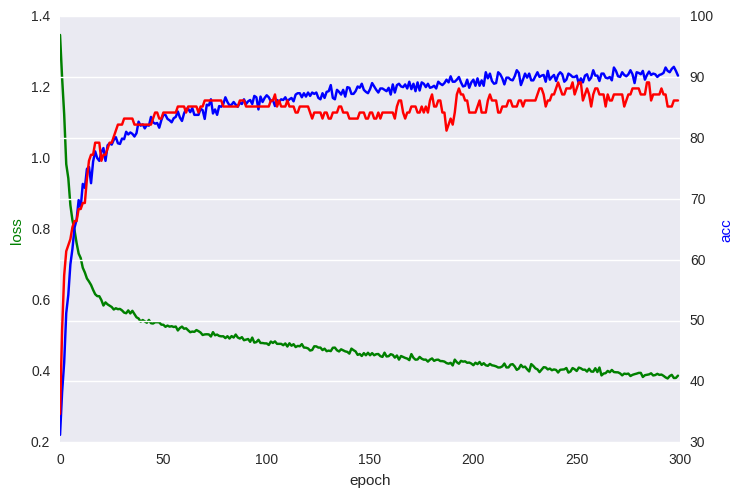

In [23]:
# Plot Acc and Loss
print(np.mean(np.array(test_acc)))
print(test_acc)
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(train_loss, 'g-')
ax2.plot(train_acc, 'b-')
ax2.plot(valid_acc, 'r-')


ax1.set_xlabel('epoch')
ax1.set_ylabel('loss', color='g')
ax2.set_ylabel('acc', color='b')
ax1.grid()


In [24]:
#TSNE
sub_list = Sub_train_kf[fid][:tr_split]    
subset = 'train'
labels = tr_y
tsne_df_concat = pd.DataFrame()
for layer in train_feature_1.keys():    
    layer_activations_dict = {'BL':train_feature_1[layer],'TP':train_feature_2[layer],
                     'BL_TP':np.hstack((train_feature_1[layer],train_feature_2[layer]))}
    
    for net_side in layer_activations_dict.keys():
        layer_activations = layer_activations_dict[net_side]
        tsne_df = computeTSNE(sub_list, fid, subset, labels, layer, net_side, layer_activations)
        tsne_df_concat = tsne_df_concat.append(tsne_df)

print(len(tsne_df_concat))
tsne_df_concat = pd.merge(tsne_df_concat,df[['PTID','ORIGPROT']],on='PTID')
print(len(tsne_df_concat))


13605
13605


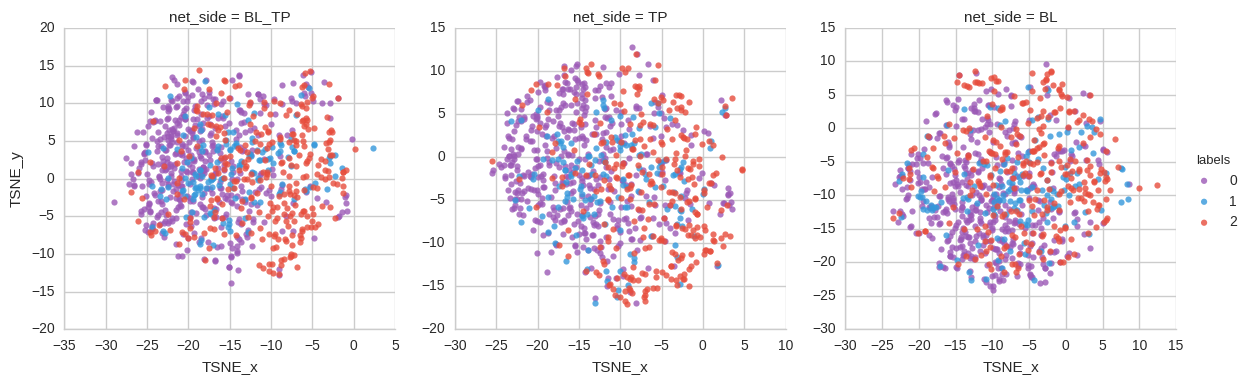

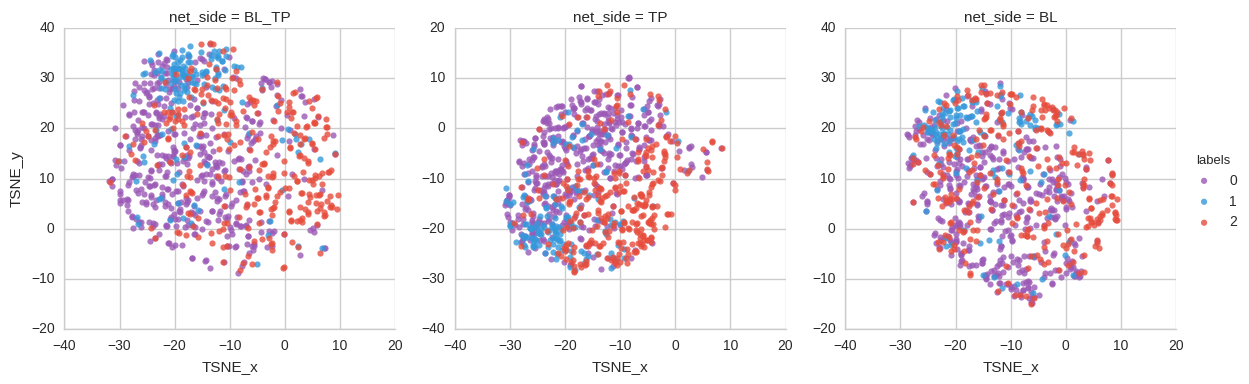

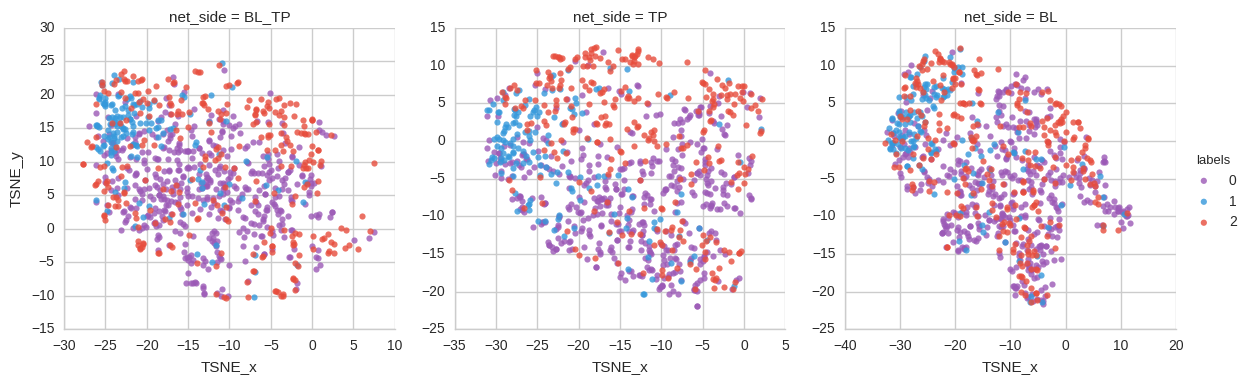

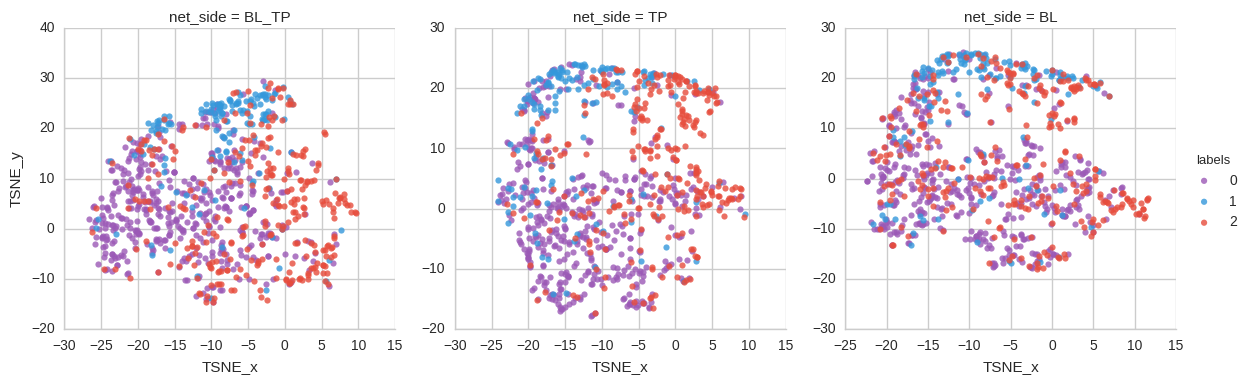

In [25]:
#Plot TSNE
flatui = ["#9b59b6", "#3498db", "#e74c3c", "#34495e", "#2ecc71", "#95a5a6"]
for layer in ['fc1','fc2','fc3','out']:    
    plot_df = tsne_df_concat[tsne_df_concat['layer']==layer]
    with sns.axes_style("whitegrid"):
        g = sns.lmplot('TSNE_x','TSNE_y',fit_reg=False,hue='labels',col='net_side',data=plot_df,
                    markers='o',size=4,sharey=False,sharex=False,palette=flatui)


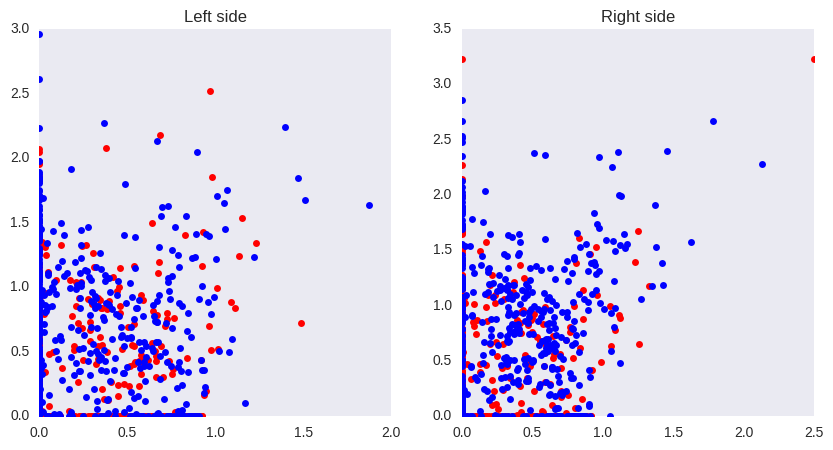

In [26]:
#Plot embeddings
f = plt.figure(figsize=(10,5))
c = ['#ff0000', '#0000ff', '#ffff00', '#00ff00', '#009999',
     '#ff00ff', '#00ffff', '#990000', '#999900', '#009900' ]
mark_size= 10
plt.subplot(1,2,1)
x = train_feature_1['out'][:,0] 
y = train_feature_1['out'][:,1] 
labels = tr_y[:,0] #left_digits
for i in range(3):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i], markersize=mark_size)

plt.grid()
plt.title('Left side')

plt.subplot(1,2,2)
x = train_feature_2['out'][:,0] 
y = train_feature_2['out'][:,1] 
for i in range(3):
    plt.plot(x[labels==i],y[labels==i],'.', c=c[i], markersize=mark_size)

plt.grid()
plt.title('Right side')

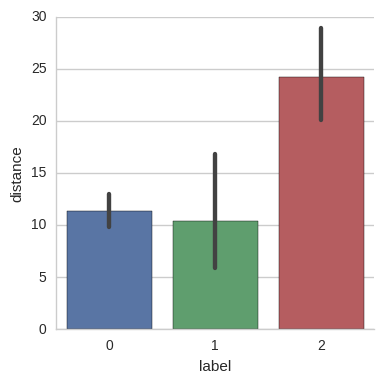

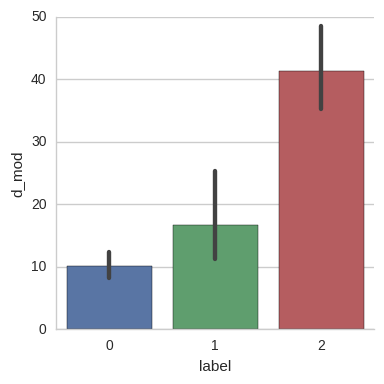

In [27]:
with sns.axes_style("whitegrid"):
    sns.factorplot(y='distance',x='label',data=tr_dist_df,kind='bar')

with sns.axes_style("whitegrid"): 
    sns.factorplot(y='d_mod',x='label',data=tr_dist_df,kind='bar')

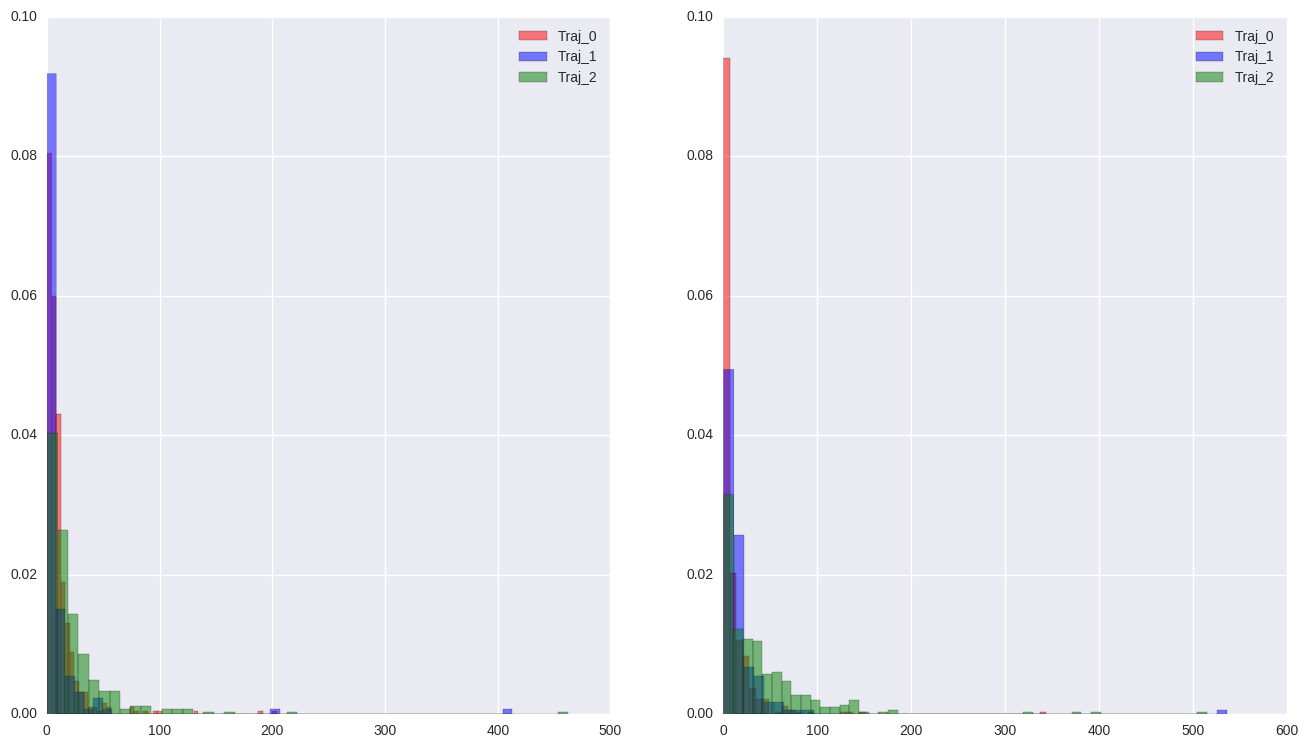

In [28]:
f = plt.figure(figsize=(16,9))
a = tr_dist_df[tr_dist_df['label']==0]['distance'].values
b = tr_dist_df[tr_dist_df['label']==1]['distance'].values
c = tr_dist_df[tr_dist_df['label']==2]['distance'].values
plt.subplot(1,2,1)
plt.hist(a,bins=50,normed=1,facecolor='red',alpha=0.5,label='Traj_0')
plt.hist(b,bins=50,normed=1,facecolor='blue',alpha=0.5,label='Traj_1')
plt.hist(c,bins=50,normed=1,facecolor='green',alpha=0.5,label='Traj_2')
plt.legend()
plt.subplot(1,2,2)
a = tr_dist_df[tr_dist_df['label']==0]['d_mod'].values
b = tr_dist_df[tr_dist_df['label']==1]['d_mod'].values
c = tr_dist_df[tr_dist_df['label']==2]['d_mod'].values
plt.hist(a,bins=50,normed=1,facecolor='red',alpha=0.5,label='Traj_0')
plt.hist(b,bins=50,normed=1,facecolor='blue',alpha=0.5,label='Traj_1')
plt.hist(c,bins=50,normed=1,facecolor='green',alpha=0.5,label='Traj_2')
plt.legend()

In [26]:
## Test code for TF slim

In [ ]:
n_classes = 5
net_arch = {'l1':50,'l2':50,'l3':8,'output':n_classes,'keep_p':0.8}
with tf.Graph().as_default():
    # Dummy placeholders for arbitrary number of 1d inputs and outputs
    inputs = tf.placeholder(tf.float32, shape=(None, 1))
    outputs = tf.placeholder(tf.float32, shape=(None, n_classes))

    # Build model
    predictions, end_points = mlp_model(inputs,net_arch=net_arch)

    # Print name and shape of each tensor.
    print("Layers")
    for k, v in end_points.items():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))

    # Print name and shape of parameter nodes  (values not yet initialized)
    print("\n")
    print("Parameters") 
    for v in slim.get_model_variables():
        print('name = {}, shape = {}'.format(v.name, v.get_shape()))
        
# batch data
x_train, y_train = produce_batch(200)
x_test, y_test = produce_batch(200)
print(np.shape(y_train),np.shape(y_test))
plt.scatter(x_train, y_train[:,0])

In [ ]:
# The following snippet trains the regression model using a mean_squared_error loss.
ckpt_dir = '/tmp/tfslim_model_test2/'

with tf.Graph().as_default():
    tf.logging.set_verbosity(tf.logging.INFO)
    
    print(x_train.shape,y_train.shape)
    inputs, targets = convert_data_to_tensors(x_train, y_train)

    # Make the model.
    predictions, nodes = mlp_model(inputs, is_training=True, net_arch=net_arch)

    # Add the loss function to the graph.
    #loss = tf.losses.mean_squared_error(labels=targets, predictions=predictions)
    one_hot_labels = tf.squeeze(slim.one_hot_encoding(y_train, n_classes))
    slim.losses.softmax_cross_entropy(predictions, one_hot_labels)
        
    # The total loss is the uers's loss plus any regularization losses.
    total_loss = slim.losses.get_total_loss()
    
    # Create some summaries to visualize the training process:
    tf.summary.scalar('losses/Total_Loss', total_loss)

    # Specify the optimizer and create the train op:
    optimizer = tf.train.AdamOptimizer(learning_rate=0.005)
    train_op = slim.learning.create_train_op(total_loss, optimizer) 

    # Run the training inside a session.
    final_loss = slim.learning.train(
        train_op,
        logdir=ckpt_dir,
        number_of_steps=5000,
        save_summaries_secs=5,
        log_every_n_steps=500)
  

print("Finished training. Last batch loss:", final_loss)
print("Checkpoint saved in %s" % ckpt_dir)


In [ ]:
with tf.Graph().as_default():
    inputs, targets = convert_data_to_tensors(x_test, y_test)
  
    # Create the model structure. (Parameters will be loaded below.)
    predictions, end_points = mlp_model(inputs, is_training=False, net_arch=net_arch)
    
    one_hot_labels = tf.squeeze(slim.one_hot_encoding(y_test, n_classes))
    # Make a session which restores the old parameters from a checkpoint.
    sv = tf.train.Supervisor(logdir=ckpt_dir)
    with sv.managed_session() as sess:
        inputs, predictions, targets = sess.run([inputs, predictions, one_hot_labels])

print(np.squeeze(inputs).shape,np.argmax(targets,1).shape,np.argmax(predictions,1).shape)
#plt.scatter(np.squeeze(inputs), np.argmax(targets,1), c='r',alpha=0.5);
plt.scatter(np.squeeze(inputs), np.argmax(predictions,1), c='b',alpha=0.5);
plt.title('red=true, blue=predicted')